In [1]:
using QuantumOptics, DiffEqNoiseProcess, PyPlot, DifferentialEquations, SparseArrays, StaticArrays, BenchmarkTools, Test, ProgressLogging, ProgressMeter

In [10]:
λ0s = LinRange(0.8, 1.2, 10)
λmods = LinRange(0.0, 0.5, 10)
ωmods = 2π * 1e-6 * [100.0, 500.0, 1000.0, 2000.0, 10000.0, 50000.0]

for i in 0:(length(λ0s)*length(λmods)*length(ωmods) - 1)
    idx1 = div(i, length(λmods) * length(ωmods))+1
    idx2 = div(i % (length(λmods) * length(ωmods)), length(ωmods))+1
    idx3 = (i % length(ωmods))+1
    println(idx1, " ", idx2, " ", idx3)
    println(λ0s[idx1], " ", λmods[idx2], " ", ωmods[idx3])
end

1 1 1
0.8 0.0 0.0006283185307179586
1 1 2
0.8 0.0 0.003141592653589793
1 1 3
0.8 0.0 0.006283185307179586
1 1 4
0.8 0.0 0.012566370614359171
1 1 5
0.8 0.0 0.06283185307179585
1 1 6
0.8 0.0 0.3141592653589793
1 2 1
0.8 0.05555555555555555 0.0006283185307179586
1 2 2
0.8 0.05555555555555555 0.003141592653589793
1 2 3
0.8 0.05555555555555555 0.006283185307179586
1 2 4
0.8 0.05555555555555555 0.012566370614359171
1 2 5
0.8 0.05555555555555555 0.06283185307179585
1 2 6
0.8 0.05555555555555555 0.3141592653589793
1 3 1
0.8 0.1111111111111111 0.0006283185307179586
1 3 2
0.8 0.1111111111111111 0.003141592653589793
1 3 3
0.8 0.1111111111111111 0.006283185307179586
1 3 4
0.8 0.1111111111111111 0.012566370614359171
1 3 5
0.8 0.1111111111111111 0.06283185307179585
1 3 6
0.8 0.1111111111111111 0.3141592653589793
1 4 1
0.8 0.16666666666666666 0.0006283185307179586
1 4 2
0.8 0.16666666666666666 0.003141592653589793
1 4 3
0.8 0.16666666666666666 0.006283185307179586
1 4 4
0.8 0.16666666666666666 0.0125

In [6]:
function smoothstep!(x)
    if x < 0
        return 0
    elseif x > 1
        return 1
    else
        return 3*x^2 - 2*x^3
    end
end

Nspin = 10
κ = 2π*0.15 # MHz
Δc = 2π*20 # MHz
ωz = 2π*0.01 # MHz
seed = 1729
tmax = 200.0 # μs
recordtimes = 200
tspan = range(0.0, tmax, recordtimes)

sb = SpinBasis(Nspin // 2)
Sx = sigmax(sb) / 2
Sy = sigmay(sb) / 2
Sz = sigmaz(sb) / 2
idOp = identityoperator(sb)
ψ0 = spindown(sb)
ψ0 = normalize!(ψ0)
Q0 = 0 # charge on the photodiode at time 0
cl0 = ComplexF64[Q0]
ψ_sc0 = semiclassical.State(ψ0, cl0)

stateG = copy(ψ_sc0)
dstateG = copy(ψ_sc0)
Nq = length(ψ_sc0.quantum)
Nc = length(ψ_sc0.classical)
Ntot = Nq + Nc
u0 = zeros(ComplexF64, Ntot)
semiclassical.recast!(u0, ψ_sc0)
# u0 = zeros(ComplexF64, Ntot)
# semiclassical.recast!(u0, ψ_sc0)
gc = sqrt(ωz*(Δc^2 + κ^2)/abs(Nspin*Δc))
grel!(t) = 1.1*smoothstep!(t/200.)

αplus = Δc/(-Δc + ωz - im*κ) + Δc/(-Δc - ωz - im*κ)
αminus = Δc/(-Δc + ωz - im*κ) - Δc/(-Δc - ωz - im*κ)

C0 = gc*sqrt(κ)/(2*Δc)*(αplus*Sx+im*αminus*Sy)
C!(t) = grel!(t)*C0

H0T1 = ωz*Sz
H0T2 = (gc)^2/(4*Δc)*Sx*(2*real(αplus)*Sx-2*imag(αminus)*Sy)
function H0!(t)
    return H0T1 - H0T2*(grel!(t))^2
end
function H_nl!(ψ,t)
    Ct = C!(t)
    return im * expect(dagger(Ct), normalize(ψ)) * Ct - 0.5im * dagger(Ct) * Ct - 0.5im * expect(dagger(Ct), normalize(ψ)) * expect(Ct, normalize(ψ)) * idOp
end
fdet_heterodyne!(t, ψ) = H0!(t) + H_nl!(ψ, t)
function fst_heterodyne!(t, ψ)
    Ct = C!(t)
    return [(Ct - expect(Ct, normalize(ψ))*idOp)/sqrt(2), im*(Ct - expect(Ct, normalize(ψ))*idOp)/sqrt(2)]
end

function f!(du, u, p, t)
    semiclassical.recast!(dstateG, du)
    semiclassical.recast!(stateG, u)
    timeevolution.dschroedinger_dynamic!(dstateG.quantum, fdet_heterodyne!, stateG.quantum, t)
    dstateG.classical[1] = expect(C!(t), normalize!(stateG.quantum))
    semiclassical.recast!(du, dstateG)
end

num_noise = length(fst_heterodyne!(0., ψ_sc0.quantum))
noise_prototype = zeros(ComplexF64, (Ntot, num_noise))

function g!(du, u, p, t)
    semiclassical.recast!(stateG, u)
    dx = @view du[1:Nq,:]
    stochastic.dschroedinger_stochastic(dx, t, stateG.quantum, fst_heterodyne!, dstateG.quantum, num_noise)
    du[Nq+1, 1] = 1.0/sqrt(2)
    du[Nq+1, 2] = 1.0im/sqrt(2)
    du
end

Base.@pure pure_inference(fout,T) = Core.Compiler.return_type(fout, T)

function fout(t, state)
    copy(state)
end
function fout_(x, t, integrator)
    semiclassical.recast!(stateG,x)
    copy(stateG)
end

out_type = pure_inference(fout, Tuple{eltype(tspan),typeof(ψ_sc0)})

CurrW = RealWienerProcess!(0.0, zeros(num_noise))
function norm_func(u, t, integrator) 
    semiclassical.recast!(stateG, u)
    normalize!(stateG)
    semiclassical.recast!(u, stateG)
end
ncb = DiffEqCallbacks.FunctionCallingCallback(norm_func;
            func_everystep=true,
            func_start=false)
out = DiffEqCallbacks.SavedValues(eltype(tspan),out_type)
scb = DiffEqCallbacks.SavingCallback(fout_,out,saveat=tspan,
                                        save_everystep=false,
                                        save_start = false,
                                        tdir = first(tspan)<last(tspan) ? one(eltype(tspan)) : -one(eltype(tspan)))
full_cb = OrdinaryDiffEq.CallbackSet(nothing, ncb, scb)
prob = SDEProblem(f!,g!, u0, (tspan[begin], tspan[end]); noise_rate_prototype=noise_prototype, noise=CurrW)
sol1 = solve(prob, RKMilGeneral(;ii_approx=IICommutative());
            adaptive=false,
            dt=(2//1)^(-11),
            save_everystep=false,
            save_start=false,
            save_end=false,
            saveat=tspan,
            callback=full_cb, seed=seed, progress=true)

psi_t = copy(out.saveval)
tout = copy(out.t);

In [34]:
file_dict = @load "results/2024-08-31/ensemblesol.jld2"

┌ Warning: type Serialization.__deserialized_types__.##245{Float64,Float64,Float64} does not exist in workspace; reconstructing
└ @ JLD2 /Users/henryhunt/.julia/packages/JLD2/lJfa6/src/data/reconstructing_datatypes.jl:641
┌ Warning: type Serialization.__deserialized_types__.##244{Operator{SpinBasis{5//1, Int64}, SpinBasis{5//1, Int64}, SparseMatrixCSC{ComplexF64, Int64}},JLD2.ReconstructedStatic{Symbol("##245{Float64,Float64,Float64}"), (:ωmod, :λmod, :λ0), Tuple{Float64, Float64, Float64}}} does not exist in workspace; reconstructing
└ @ JLD2 /Users/henryhunt/.julia/packages/JLD2/lJfa6/src/data/reconstructing_datatypes.jl:641
┌ Warning: type Serialization.__deserialized_types__.##243{JLD2.ReconstructedMutable{Symbol("##244{Operator{SpinBasis{5//1, Int64}, SpinBasis{5//1, Int64}, SparseMatrixCSC{ComplexF64, Int64}},JLD2.ReconstructedStatic{Symbol(\"##245{Float64,Float64,Float64}\"), (:ωmod, :λmod, :λ0), Tuple{Float64, Float64, Float64}}}"), (:C0, :grel!), Tuple{Any, JLD2.ReconstructedS

1-element Vector{Symbol}:
 :sol

In [38]:
sizeof(file_dict[1])

3

In [63]:
using JLD2, QuantumOptics, DiffEqNoiseProcess, DifferentialEquations
@load "results/2024-08-31/ensemblesol.jld2" sol

1-element Vector{Symbol}:
 :sol

In [62]:
sol[3].alg

RKMilGeneral{IICommutative, Nothing}(:Ito, IICommutative(), 1, nothing)

In [25]:
length(sol)

50

In [26]:
50*208

10400

### Around 1037 seconds for each sim to run or 16 minutes

In [ ]:
field = map(n->expect(C(tout[n]), psi_t[n]), 1:length(tout))
plot(tout, real.(field), label="Real")
plot(tout, imag.(field), label="Imag")
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle C(t) \\rangle\$")
PyPlot.display_figs()

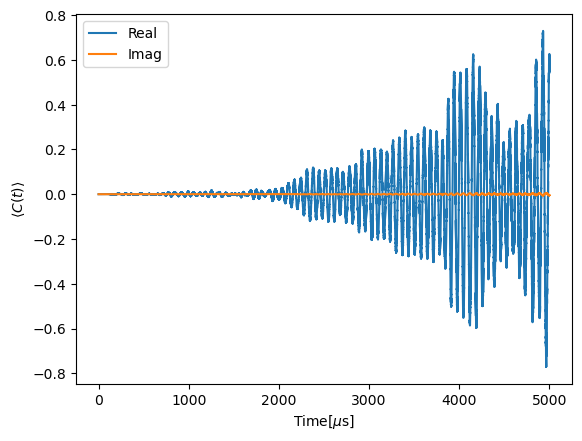

In [ ]:
field = map(n->expect(C(tout[n]), psi_t[n]), 1:length(tout))
plot(tout, real.(field), label="Real")
plot(tout, imag.(field), label="Imag")
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle C(t) \\rangle\$")
PyPlot.display_figs()

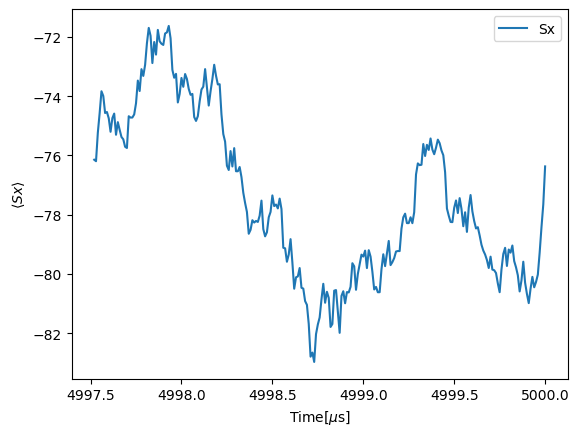

In [ ]:
plot(tout[end-500:end], expect(Sx, psi_t)[end-500:end], label="Sx")
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


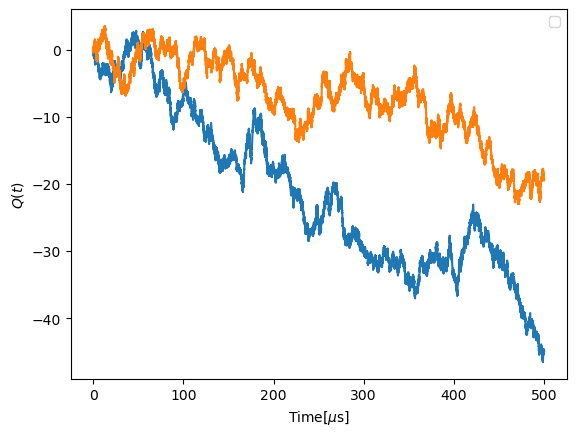

In [21]:
Q = map(x->x.classical[1], psi_t)
plot(tout, real.(Q))
plot(tout, imag.(Q))
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$ Q(t)\$")
PyPlot.display_figs()

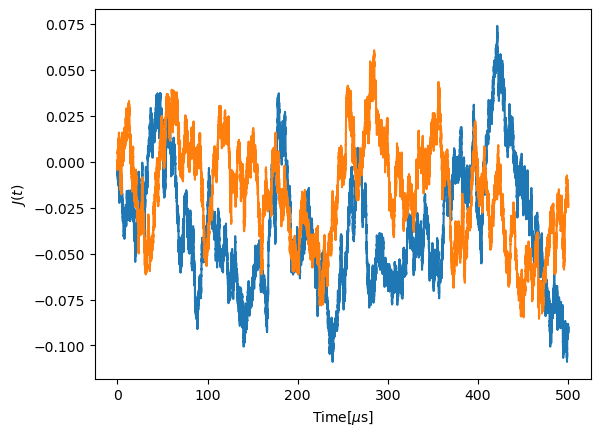

In [47]:
Q = map(x->x.classical[1], psi_t)
dt = tout[2] - tout[1]
J = (Q[2:end] - Q[1:end-1])/dt
Jfilt = exp_filter(J, 10000*dt, dt)
plot(tout[1:end-1], real.(Jfilt))
plot(tout[1:end-1], imag.(Jfilt))
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, grel.(tout), linestyle="dashed")
# legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$ J(t)\$")
PyPlot.display_figs()

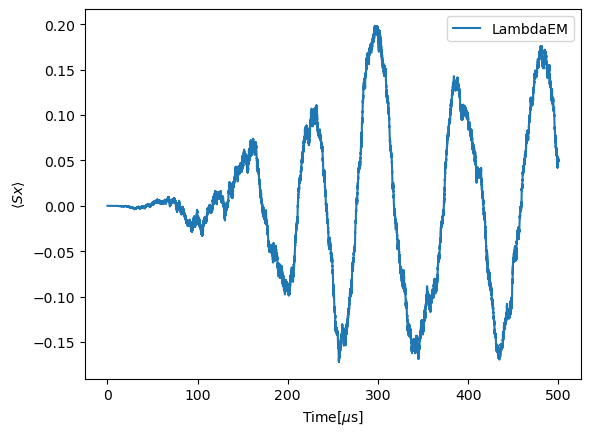

In [20]:
plot(tout, expect(Sx, psi_t), label="LambdaEM")
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, 5/0.9*grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

In [15]:
diff = psi_t_SOSRI2[end] - psi_t_EM[end]
print(dagger(diff)*diff)

0.010472472731642386 + 9.356539586650395e-20im

In [ ]:
gc = sqrt(ωz*(Δc^2 + κ^2)/abs(Nspin*Δc))
grel(t) = 1.0 #0.9*smoothstep(t/200.)

αplus = Δc/(-Δc + ωz - im*κ) + Δc/(-Δc - ωz - im*κ)
αminus = Δc/(-Δc + ωz - im*κ) - Δc/(-Δc - ωz - im*κ)

C(t) = (grel(t)*gc)*sqrt(κ)/(2*Δc)*(αplus*Sx+im*αminus*Sy)
H0(t) = ωz*Sz - (grel(t)*gc)^2/(4*Δc)*Sx*(2*real(αplus)*Sx-2*imag(αminus)*Sy)
H_nl(ψ,t) = im * expect(dagger(C(t)), normalize(ψ)) * C(t) - 0.5im * dagger(C(t)) * C(t) - 0.5im * expect(dagger(C(t)), normalize(ψ)) * expect(C(t), normalize(ψ)) * idOp
fdet_heterodyne(t, ψ) = H0(t) + H_nl(ψ, t)
fst_heterodyne(t, ψ) = [C(t) - expect(C(t), normalize(ψ)) * idOp]

Z1 = WienerProcess(0.0, im * 0.0, im * 0.0)
#tout, psi_t_EM
tout, psi_t_EM = stochastic.schroedinger_dynamic(tspan, ψ0, fdet_heterodyne, fst_heterodyne; normalize_state=true, noise=Z1, seed=seed, alg=RKMilGeneral(), dt=0.0001, reltol=10^-4, abstol=10^-4, maxiters=10^8, adaptive=false);

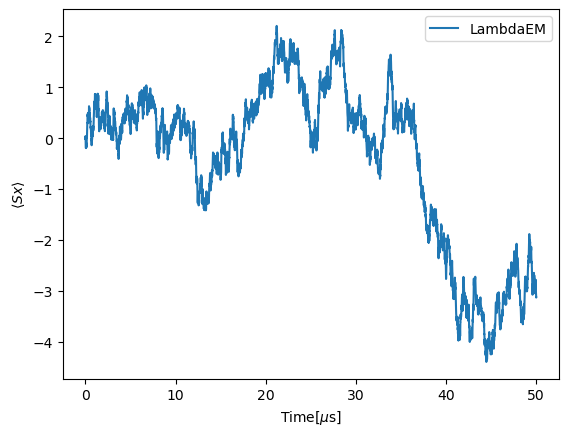

In [111]:
plot(tout, map(x->x.classical, psi_t), label="LambdaEM")
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, 5/0.9*grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

In [52]:
using DiffEqNoiseProcess, SciMLBase, Plots
seed = 1337

Z1 = WienerProcess(0.0, im * 0.0, im * 0.0, reseed=false)
prob1 = NoiseProblem(Z1, (0.0, 10.0), seed=seed)
sol1 = solve(prob1; dt = 0.1)

Z2 = WienerProcess(0.0, im * 0.0, im * 0.0, reseed=false)
prob2 = NoiseProblem(Z2, (0.0, 10.0), seed=seed)
sol2 = solve(prob1; dt = 0.101);

plot(sol1.t, real.(sol1.u), label="Version 1")
Plots.savefig("V1.png")

plot(sol2.t, real.(sol2.u), label="Version 2")
Plots.savefig("V2.png");

"/Volumes/commondrive/Users/hshunt/LabNotebooks/DickeModel/V2.png"

In [6]:
(gc)^2/(4*Δc)

0.0015708846840882791

In [4]:
seed = Int(round(mod(time()*300,1000)))

280

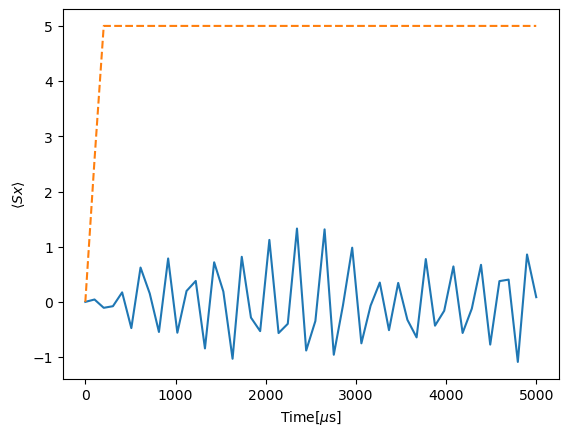

In [25]:
plot(tout, expect(Sx, psi_t))
plot(tout, 5/0.9*grel.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

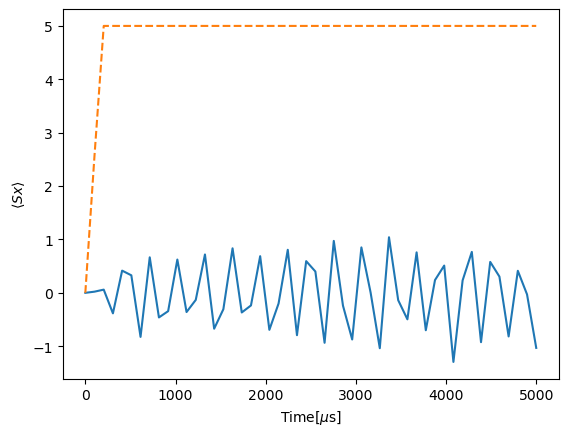

In [16]:
plot(tout, expect(Sx, psi_t))
plot(tout, 5/0.9*grel.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

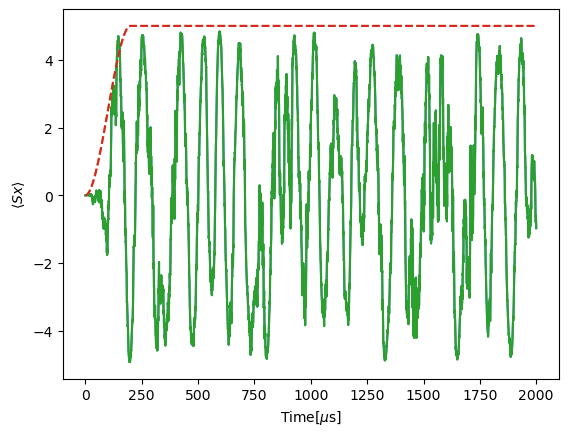

In [110]:
ax = gca()
ax.plot(tout, expect(Sx, psi_t))
ax.plot(tout, 5/0.9*λrelfnc.(tout), linestyle="dashed")
ax.set_xlabel("Time[\$\\mu\$s]")
ax.set_ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

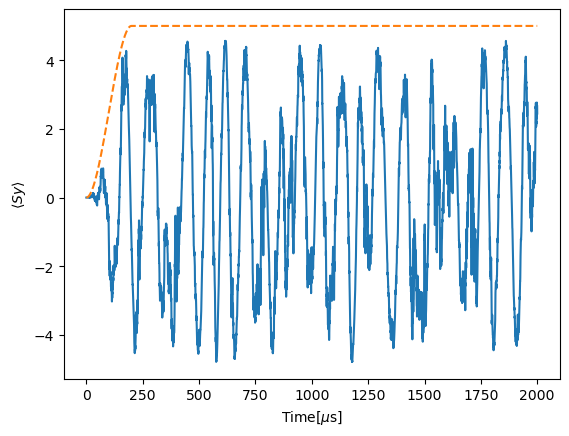

In [103]:
plot(tout, expect(Sy, psi_t))
plot(tout, 5/0.9*λrelfnc.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sy \\rangle\$")
PyPlot.display_figs()

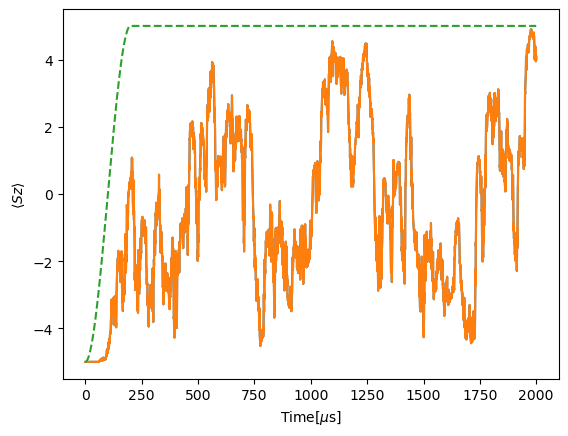

In [99]:
plot(tout, expect(Sz, psi_t))
plot(tout, 10/0.9*λrelfnc.(tout).-5, linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sz \\rangle\$")
PyPlot.display_figs()

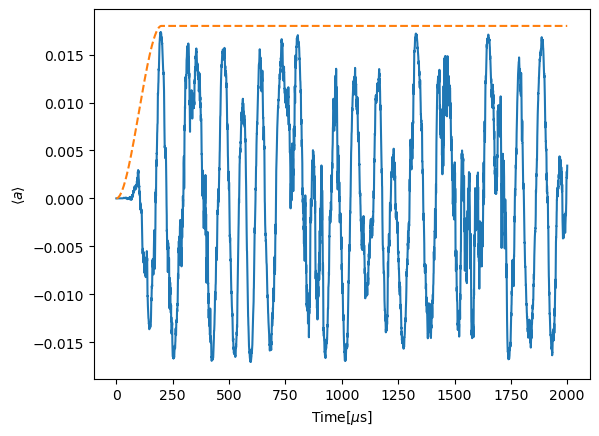

In [100]:
plot(tout, expect(a, psi_t))
plot(tout, 0.02*λrelfnc.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle a \\rangle\$")
PyPlot.display_figs()

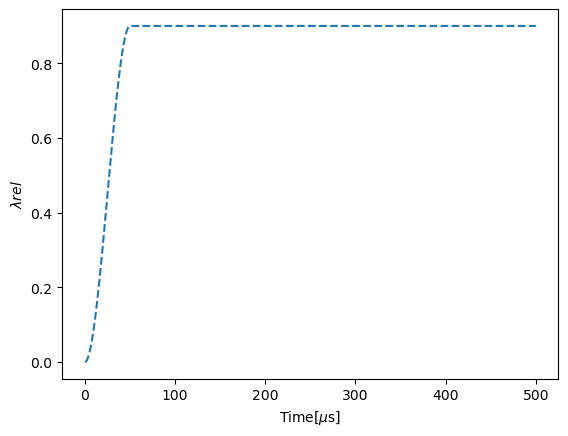

In [81]:
plot(tout, λrelfnc.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\lambda rel\$")
PyPlot.display_figs()

In [44]:
expect(Sz, psi_t)[1]

-50.0 + 0.0im

In [19]:
tout = load("DickeModelRslts4/seed=42lambda=1.034.jld2", "tout");
psi_t = load("DickeModelRslts4/seed=42lambda=1.034.jld2", "psi_t");
W = load("DickeModelRslts4/seed=42lambda=1.034.jld2", "W");

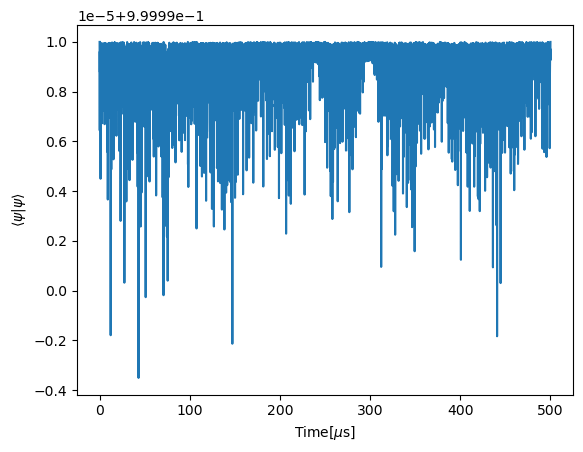

In [47]:
fb, sb, bases, a, Sx, Sy, Sz, idOp = make_operators(4, 100)
plot(tout, expect(idOp, psi_t))
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle \\psi | \\psi \\rangle\$")
PyPlot.display_figs()

In [37]:
W(0.1)

(0.2384303867108135 - 0.3203593358009233im, -0.8781749128519063 - 0.20590953906942272im)

In [ ]:
white_noise = zeros(ComplexF64, length(tout))
prev_index = 1
new_index = 1
for i = 2:length(tout)
    new_index = prev_index
    while W.t[new_index] < tout[i]
        new_index += 1
    end
    white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
    prev_index = new_index
end

In [11]:
seed = 26
λrel = 1.0
κ=200.0

tout, psi_t, W, fb, sb, bases, a, Sx, Sy, Sz = single_run_dicke_hetrodyne(seed, λrel, κ=κ, tmax=500.0, Nspin=100);

Running with seed: 24

In [8]:
seed = 24
λrels = LinRange(0.0, 3.0, 30)
λrel = λrels[25]
tout = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "tout");
psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "psi_t");
W = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "W");

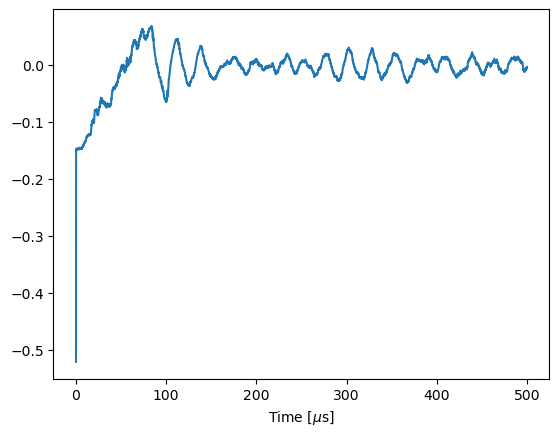

In [14]:
fb, sb, bases, a, Sx, Sy, Sz = make_operators(4, 100)
plot(tout, expect(a, psi_t))
xlabel("Time [\$\\mu\$s]")
ylabel("\$\\langle a \\rangle\$")
PyPlot.display_figs()

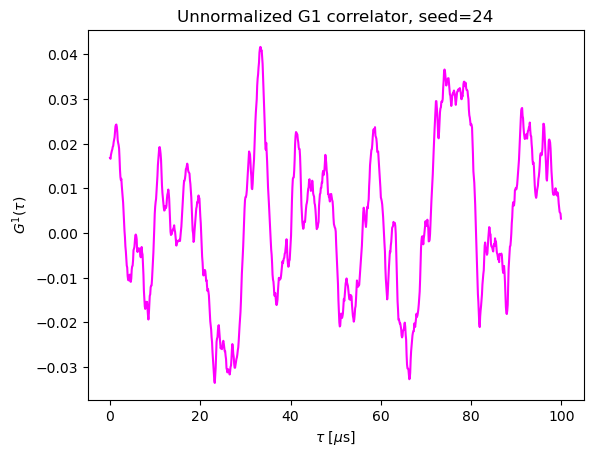

In [13]:
# seeds = [42, 1337, 1729, 724, 333, 137, 31459, 271828, 24, 240]
seed = 24
λrels = LinRange(0.0, 3.0, 30)
# short_list = λrels[1:7]
cm = get_cmap(:spring)
κ=200.0
fb, sb, bases, a, Sx, Sy, Sz = make_operators(4, 100)

for λrel in λrels[1:1]
    tout = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "tout");
    psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "psi_t");
    W = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "W");


    white_noise = zeros(ComplexF64, length(tout))
    prev_index = 1
    new_index = 1
    for i = 2:length(tout)
        new_index = prev_index
        while W.t[new_index] < tout[i]
            new_index += 1
        end
        white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
        prev_index = new_index
    end

    Jhet = sqrt(2*κ)*expect(a, psi_t) + conj(white_noise);
    dt = tout[2] - tout[1]
    tau = dt*10
    Jhetfilt = exp_filter(Jhet, tau, dt)
    time_bins = 1000
    time = tout[1:time_bins]

    Background = exp.(-time/tau)/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau))

    # plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins))#  - Background
    # plot(time, Background)
    plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - Background, color=cm(λrel/λrels[end]), label="$(round(λrel,digits=2))")
    # plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - two_point_correlator(exp_filter(conj(white_noise), tau, dt), tout, dt, time_bins))
end
# legend()
xlabel(L"$\tau$ [$\mu$s]")
ylabel(L"$G^1 (\tau)$")
# PyPlot.colorbar()
PyPlot.title("Unnormalized G1 correlator, seed=$(seed)")
PyPlot.display_figs()

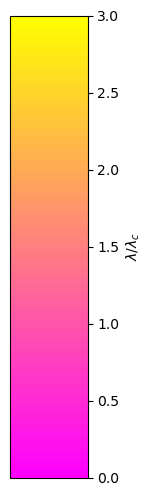

In [25]:
fig, ax = PyPlot.subplots(figsize=(1,6))
cm = get_cmap(:spring)
norm = matplotlib[:colors][:Normalize](vmin=0.0, vmax=3.0)
cb1 = matplotlib[:colorbar][:ColorbarBase](ax, cmap=cm, norm=norm)
cb1.set_label("\$\\lambda/\\lambda_c\$")
PyPlot.display_figs()

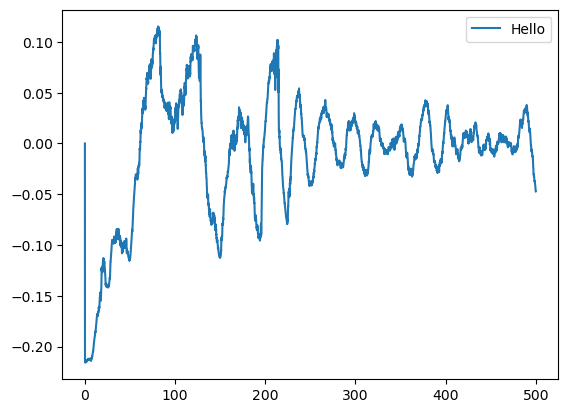

In [53]:
plot(tout, imag.(expect(a, psi_t)), label="Hello")
legend()
PyPlot.display_figs()

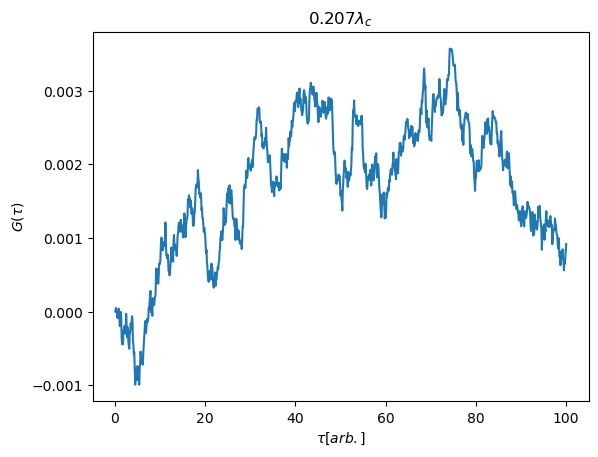

In [27]:
seeds = [42, 1337, 1729, 724, 333, 137, 31459, 271828, 24, 240]
seed = 42
λrel = 0.207
κ=200.0
tout = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "tout");
psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "psi_t");
W = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "W");

white_noise = zeros(ComplexF64, length(tout))
prev_index = 1
new_index = 1
for i = 2:length(tout)
    new_index = prev_index
    while W.t[new_index] < tout[i]
        new_index += 1
    end
    white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
    prev_index = new_index
end

Jhet = sqrt(2*κ)*expect(a, psi_t) + conj(white_noise);
dt = tout[2] - tout[1]
tau = dt*1000
time_bins = 1000
time = dt*collect(1:time_bins)

Background = zeros(length(time))
Background[1] = 1/dt

# plot(time, two_point_correlator(Jhet, tout, dt, time_bins))#  - Background
# plot(time, Background)
plot(time, exp_filter(two_point_correlator(Jhet, tout, dt, time_bins) - Background, tau, dt))
# plot(time, two_point_correlator(Jhet, tout, dt, time_bins) - two_point_correlator(conj(white_noise), tout, dt, time_bins))
xlabel(L"\tau [arb.]")
ylabel(L"$G(\tau)$")
PyPlot.title("$(λrel)\$\\lambda_c\$")
PyPlot.display_figs()

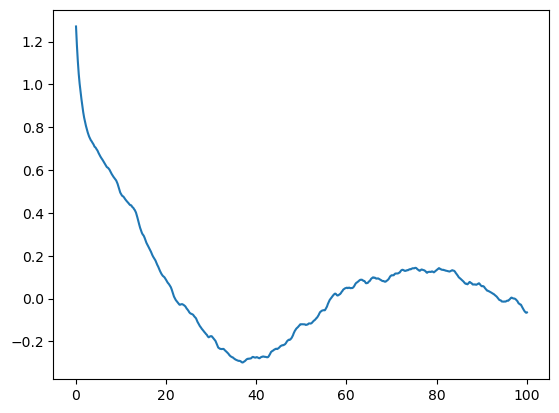

In [23]:
plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - two_point_correlator(exp_filter(conj(white_noise), tau, dt), tout, dt, time_bins))
PyPlot.display_figs()

In [70]:
two_point_correlator(Jhetfilt, tout, dt, 300)[2]

0.5062638157327481 + 0.00455229561347181im

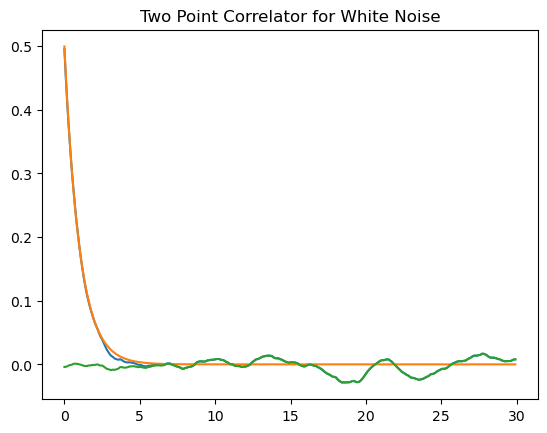

Pre-factor Actual: 0.49013553410966115-0.5106688003821964 	 Expected: 0.49953379120384234
 Decay time: 0.9883958362112918-1.050598005985766 	 Expected: 0.9999000000000001


In [10]:
W = WienerProcess(0.,im*0., im*0.)
time_total = LinRange(0.0,1000.0,10000)
time = time_total[1:300]
dt = time[2] - time[1]
tau = 10*dt
noise = make_white_noise(time_total, W)
filt_noise = exp_filter(noise, tau, dt)
Background = exp.(-time/tau)/dt*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau))
Bin_var = 1/dt

two_point = real.(two_point_correlator(filt_noise, time_total, dt, 300))

@. model(x,p) = p[1]*exp(-x*p[2])
fit = curve_fit(model, time,two_point, [1/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau)), 1/tau])

Background = exp.(-time/tau)*(1/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau)))

rslt = confidence_interval(fit, 0.1)
println("Pre-factor Actual: $(rslt[1][1])-$(rslt[1][2]) \t Expected: $(1/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau)))\n Decay time: $(rslt[2][1])-$(rslt[2][2]) \t Expected: $(1/tau)")

# plot(time[1:300], two_point_correlator(noise, time, dt, 300))#  - Background
plot(time, two_point_correlator(filt_noise, time_total, dt, 300))
plot(time, Background)
# plot(time, two_point_correlator(noise, time_total, dt, 300))
# plot(time, Bin_var*ones(length(time)))
plot(time, two_point_correlator(filt_noise, time_total, dt, 300)-Background)
PyPlot.title("Two Point Correlator for White Noise")
PyPlot.display_figs()